<a href="https://colab.research.google.com/github/stephanyresque/Multimodal/blob/main/clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop

## Instalações de pacotes

In [ ]:
# !pip install torch torchvision transformers datasets tqdm
# !pip install datasets[image] pillow

In [4]:
from google.colab import files
import nbformat

uploaded = files.upload()
notebook_path = next(iter(uploaded.keys()))

nb = nbformat.read(notebook_path, as_version=4)
for cell in nb.cells:
    if 'widgets' in cell.metadata:
        cell.metadata.pop('widgets')
nbformat.write(nb, notebook_path)

print(f"metadata.widgets removido de {notebook_path} com sucesso!")


Saving clip.ipynb to clip.ipynb
metadata.widgets removido de clip.ipynb com sucesso!


## Imports

In [ ]:
import os
from zipfile import ZipFile, BadZipFile
import random
import pickle
import heapq
import json
from collections import defaultdict

import torch
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
from tqdm import tqdm

## Carregando dataset COCO

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

--2025-06-24 10:33:15--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.27.94, 52.217.232.201, 3.5.29.127, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.27.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco_train2017.zip’

coco_train2017.zip  100%[===================>]  18.01G  20.8MB/s    in 4m 59s  

2025-06-24 10:38:14 (61.6 MB/s) - ‘coco_train2017.zip’ saved [19336861798/19336861798]

--2025-06-24 10:38:14--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.160.9, 54.231.163.97, 16.182.38.241, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.160.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[===================

In [ ]:
# 2. Função para extrair arquivos ZIP
def extrair_arquivo(caminho):
    try:
        with ZipFile(caminho + ".zip") as zipf:
            zipf.extractall(caminho)
        os.remove(caminho + ".zip")
    except BadZipFile as e:
        print("Erro ao extrair:", e)

# Extrair dados do COCO
extrair_arquivo("./coco_train2017")
extrair_arquivo("./coco_val2017")
extrair_arquivo("./coco_ann2017")

## Modelo e configurações iniciais

In [ ]:
# 3. Configurações iniciais
dispositivo = "cuda" if torch.cuda.is_available() else "cpu"
diretorio_val = "./coco_val2017/val2017"
caminho_anotacoes = "./coco_ann2017/annotations/captions_val2017.json"

# 4. Carregar modelo CLIP
modelo = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(dispositivo)
processador = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
modelo.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

## Organização dos dados

In [ ]:
# Precomputar embeddings das imagens de validação
caminhos_imagens = [
    os.path.join(diretorio_val, f)
    for f in os.listdir(diretorio_val) if f.endswith(".jpg")
]
embeddings_imagem = {}
for caminho in tqdm(caminhos_imagens, desc="Pré-computando embeddings"):
    img = Image.open(caminho).convert("RGB")
    inputs = processador(images=img, return_tensors="pt").to(dispositivo)
    with torch.no_grad():
        emb = modelo.get_image_features(**inputs)
        emb = emb / emb.norm(dim=-1, keepdim=True)
    img_id = int(os.path.basename(caminho).split(".")[0])
    embeddings_imagem[img_id] = emb.cpu()

# Salvar embeddings em arquivo para reutilização
with open("embeddings_val.pkl", "wb") as f:
    pickle.dump(embeddings_imagem, f)

# Carregar legendas e organizar por ID de imagem
with open(caminho_anotacoes, 'r') as f:
    anotacoes = json.load(f)
legendas_por_imagem = defaultdict(list)
for entry in anotacoes['annotations']:
    img_id = entry['image_id']
    legendas_por_imagem[img_id].append(entry['caption'])

A saída de streaming foi truncada nas últimas 5000 linhas.
Pré-computando embeddings: 100%|██████████| 5000/5000 [21:19<00:00,  3.91it/s]


## Funções auxiliares

In [ ]:
# Função para criar exemplos com mistura de distractores difíceis e fáceis
def criar_exemplo_calibrado(
    id_alvo, embeddings, modelo, processador,
    k=9, tamanho_pool=2000, n_facil=7
):
    # Selecionar pool de imagens
    pool = random.sample(list(embeddings.keys()), tamanho_pool)
    pool = [i for i in pool if i != id_alvo]
    # Escolher legenda
    legenda = random.choice(legendas_por_imagem[id_alvo])
    # Computar embedding de texto
    inputs = processador(text=[legenda], return_tensors="pt", padding=True).to(dispositivo)
    with torch.no_grad():
        emb_texto = modelo.get_text_features(**inputs)
        emb_texto = emb_texto / emb_texto.norm(dim=-1, keepdim=True)
        emb_texto = emb_texto.cpu()
    # Calcular similaridade com imagens no pool
    sims = [(float((emb_texto @ embeddings[i].T)), i) for i in pool]
    # Selecionar distractores difíceis
    top_duros = [i for _, i in heapq.nlargest(k - n_facil, sims, key=lambda x: x[0])]
    # Adicionar distractores fáceis
    faciles = random.sample([i for i in pool if i not in top_duros], n_facil)
    distractores = top_duros + faciles
    return {
        "legenda": legenda,
        "id_correto": id_alvo,
        "ids_distratores": distractores
    }

# Função para calcular Recall@1
def calcular_recall_1(exemplo, modelo, processador):
    # Preparar imagens
    ids = [exemplo["id_correto"]] + exemplo["ids_distratores"]
    imagens = [
        Image.open(f"{diretorio_val}/{str(i).zfill(12)}.jpg") for i in ids
    ]
    # Processar entrada CLIP
    inputs = processador(text=[exemplo["legenda"]], images=imagens,
                         return_tensors="pt", padding=True).to(dispositivo)
    with torch.no_grad():
        saida = modelo(**inputs)
        logits = saida.logits_per_text.cpu().numpy()[0]
    # Verificar top-1
    indice_top1 = logits.argmax()
    return int(ids[indice_top1] == exemplo["id_correto"])

## Calculando o recall@1

In [ ]:
# Carregar embeddings do arquivo
with open("embeddings_val.pkl", "rb") as f:
    embeddings_imagem = pickle.load(f)

# Gerar exemplos calibrados e avaliar
N = 2000
exemplos = [
    criar_exemplo_calibrado(
        id_alvo=random.choice(list(legendas_por_imagem.keys())),
        embeddings=embeddings_imagem,
        modelo=modelo,
        processador=processador,
        k=9,
        tamanho_pool=2000,
        n_facil=7
    )
    for _ in range(N)
]

# Calcular recall geral
acertos = sum(calcular_recall_1(ex, modelo, processador) for ex in tqdm(exemplos))
print(f"Recall@1 calibrado: {acertos / N:.2%}")

100%|██████████| 2000/2000 [55:39<00:00,  1.67s/it]

Recall@1 calibrado: 40.20%


## Analisando os erros

In [ ]:
import random, numpy as np, torch
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)


def calcular_recall_k(exemplo, modelo, processador, k=5):
    ids = [exemplo["id_correto"]] + exemplo["ids_distratores"]
    imagens = [Image.open(f"{diretorio_val}/{str(i).zfill(12)}.jpg") for i in ids]
    inputs = processador(text=[exemplo["legenda"]], images=imagens,
                         return_tensors="pt", padding=True).to(dispositivo)
    with torch.no_grad():
        logits = modelo(**inputs).logits_per_text.cpu().numpy()[0]
    topk = logits.argsort()[-k:][::-1]
    return int(exemplo["id_correto"] in [ids[idx] for idx in topk])

def calcular_mrr(exemplo, modelo, processador):
    ids = [exemplo["id_correto"]] + exemplo["ids_distratores"]
    imagens = [Image.open(f"{diretorio_val}/{str(i).zfill(12)}.jpg") for i in ids]
    inputs = processador(text=[exemplo["legenda"]], images=imagens,
                         return_tensors="pt", padding=True).to(dispositivo)
    with torch.no_grad():
        logits = modelo(**inputs).logits_per_text.cpu().numpy()[0]
    ranks = logits.argsort()[::-1]
    rank_pos = list(ranks).index(0) + 1
    return 1.0 / rank_pos


import pandas as pd

regs = []
for ex in tqdm(exemplos, desc="Rodando avaliação detalhada"):
    regs.append({
        "legenda": ex["legenda"],
        "hit@1": calcular_recall_1(ex, modelo, processador),
        "hit@5": calcular_recall_k(ex, modelo, processador, k=5),
        "mrr":   calcular_mrr(ex, modelo, processador)
    })
df = pd.DataFrame(regs)
print("Recall@1:", df["hit@1"].mean(),
      "Recall@5:", df["hit@5"].mean(),
      "MRR:", df["mrr"].mean())


Rodando avaliação detalhada: 100%|██████████| 2000/2000 [2:45:29<00:00,  4.96s/it]


Recall@1: 0.402 Recall@5: 0.997 MRR: 0.6198374999999999


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
df["num_tokens"]    = df["legenda"].apply(lambda t: len(t.split()))
df["tamanho_chars"] = df["legenda"].str.len()

# Função de classificação de erro
import re

def classificar_erro(legenda):
    if len(legenda) < 3:
        return "muito_curta"
    if len(legenda) > 50:
        return "muito_longa"
    if re.search(r"\b(e|and|,)\b", legenda):
        return "ambigua"
    return "outros"

df_fail = df[df["hit@1"] == 0].copy()
df_fail["tipo_erro"] = df_fail["legenda"].apply(classificar_erro)


# Análise de distribuições
print("Distribuição de erros:")
print(df_fail["tipo_erro"].value_counts(normalize=True))

# visualizar contagens absolutas também
print(df_fail["tipo_erro"].value_counts())


# Explorar exemplos de cada classe
for categoria in df_fail["tipo_erro"].unique():
    print(f"\n=== Exemplos de {categoria} ===")
    display(df_fail[df_fail["tipo_erro"] == categoria].head(5)[["legenda"]])

Distribuição de erros:
tipo_erro
outros         0.471572
muito_longa    0.441472
ambigua        0.086957
Name: proportion, dtype: float64
tipo_erro
outros         564
muito_longa    528
ambigua        104
Name: count, dtype: int64

=== Exemplos de outros ===


,legenda
1,A man watching two elephants behind a wire fence.
15,A clock that is on the side of a building.
17,a little boy in a blue shirt is playing baseball
18,A picture of a single surfer riding a large wave.
21,A bird that is sitting on a rock near the water.



=== Exemplos de muito_longa ===


,legenda
2,Surboarders are in the water and waiting on th...
3,A giraffe and two zebras in a dirt area next t...
5,A large slice of pizza with cheese and marinar...
9,A middle aged black woman is standing behind a...
10,A barefoot woman walking with a tennis racket ...



=== Exemplos de ambigua ===


,legenda
7,a blue and yellow train a building and some cars
46,A photo of a man and his wife on a bed
74,The cake is prepared and ready to be eaten.
110,a plate of polents a tomatoe and brocolli
119,"A toilet, counter and shower in a bathroom."


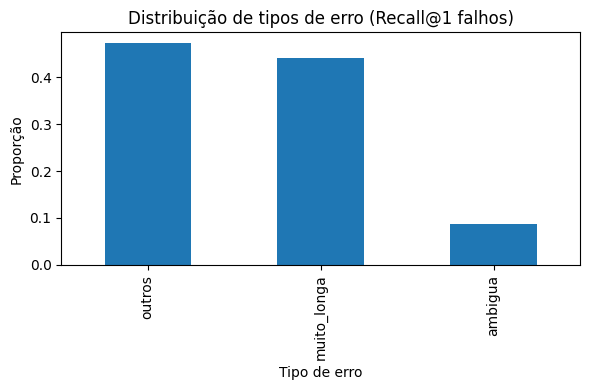

Top-3 categorias de erro:
  • outros: 47.2%
  • muito_longa: 44.1%
  • ambigua: 8.7%

=== Exemplos de outros ===


,legenda
1,A man watching two elephants behind a wire fence.
15,A clock that is on the side of a building.
17,a little boy in a blue shirt is playing baseball



=== Exemplos de muito_longa ===


,legenda
2,Surboarders are in the water and waiting on th...
3,A giraffe and two zebras in a dirt area next t...
5,A large slice of pizza with cheese and marinar...



=== Exemplos de ambigua ===


,legenda
7,a blue and yellow train a building and some cars
46,A photo of a man and his wife on a bed
74,The cake is prepared and ready to be eaten.


In [ ]:
import matplotlib.pyplot as plt

vc = df_fail["tipo_erro"].value_counts(normalize=True)

plt.figure(figsize=(6,4))
vc.plot.bar()
plt.title("Distribuição de tipos de erro (Recall@1 falhos)")
plt.ylabel("Proporção")
plt.xlabel("Tipo de erro")
plt.tight_layout()
plt.show()

top3 = vc.head(3)
print("Top-3 categorias de erro:")
for cat, pct in top3.items():
    print(f"  • {cat}: {pct:.1%}")

for cat in top3.index:
    print(f"\n=== Exemplos de {cat} ===")
    display(df_fail[df_fail["tipo_erro"] == cat].head(3)[["legenda"]])


In [ ]:
#Filtrar só os erros “outros”
df_outros = df_fail[df_fail["tipo_erro"] == "outros"].copy()

print("Estatísticas de palavras (outros):")
print(df_outros["num_tokens"].describe(), "\n")
print("Estatísticas de caracteres (outros):")
print(df_outros["tamanho_chars"].describe(), "\n")

print("===== 10 exemplos aleatórios de 'outros' =====")
for leg in df_outros["legenda"].sample(10, random_state=42).tolist():
    print(" •", leg)
print("\n")

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    ngram_range=(1,2),
    max_features=20,
    stop_words=None
)
X = vectorizer.fit_transform(df_outros["legenda"])
freqs = X.toarray().sum(axis=0)
ngrams = vectorizer.get_feature_names_out()

print("Top 20 uni-/bi-grams mais comuns em 'outros':")
for ng, f in sorted(zip(ngrams, freqs), key=lambda x: x[1], reverse=True):
    print(f"{ng}: {f}")


Estatísticas de palavras (outros):
count    564.000000
mean       9.200355
std        1.083019
min        7.000000
25%        8.000000
50%        9.000000
75%       10.000000
max       13.000000
Name: num_tokens, dtype: float64 

Estatísticas de caracteres (outros):
count    564.000000
mean      44.062057
std        4.311748
min       30.000000
25%       41.000000
50%       45.000000
75%       48.000000
max       50.000000
Name: tamanho_chars, dtype: float64 

===== 10 exemplos aleatórios de 'outros' =====
 • Two cows in a large green grassy field.
 • Two surfers walking on a beach to the ocean.
 • A stop sign gives traffic a frown face.
 • a group of people who are posing for a picture
 • a cat is sleeping on the hood of a car
 • A man in  a jacket standing near a  giant tv
 • A row of several types of pastries on display.
 • A group of cows in a fenced in area.
 • A corner of a living room with a TV in it.
 • A white plate with lots topped with garlic bread.


Top 20 uni-/bi-grams ma

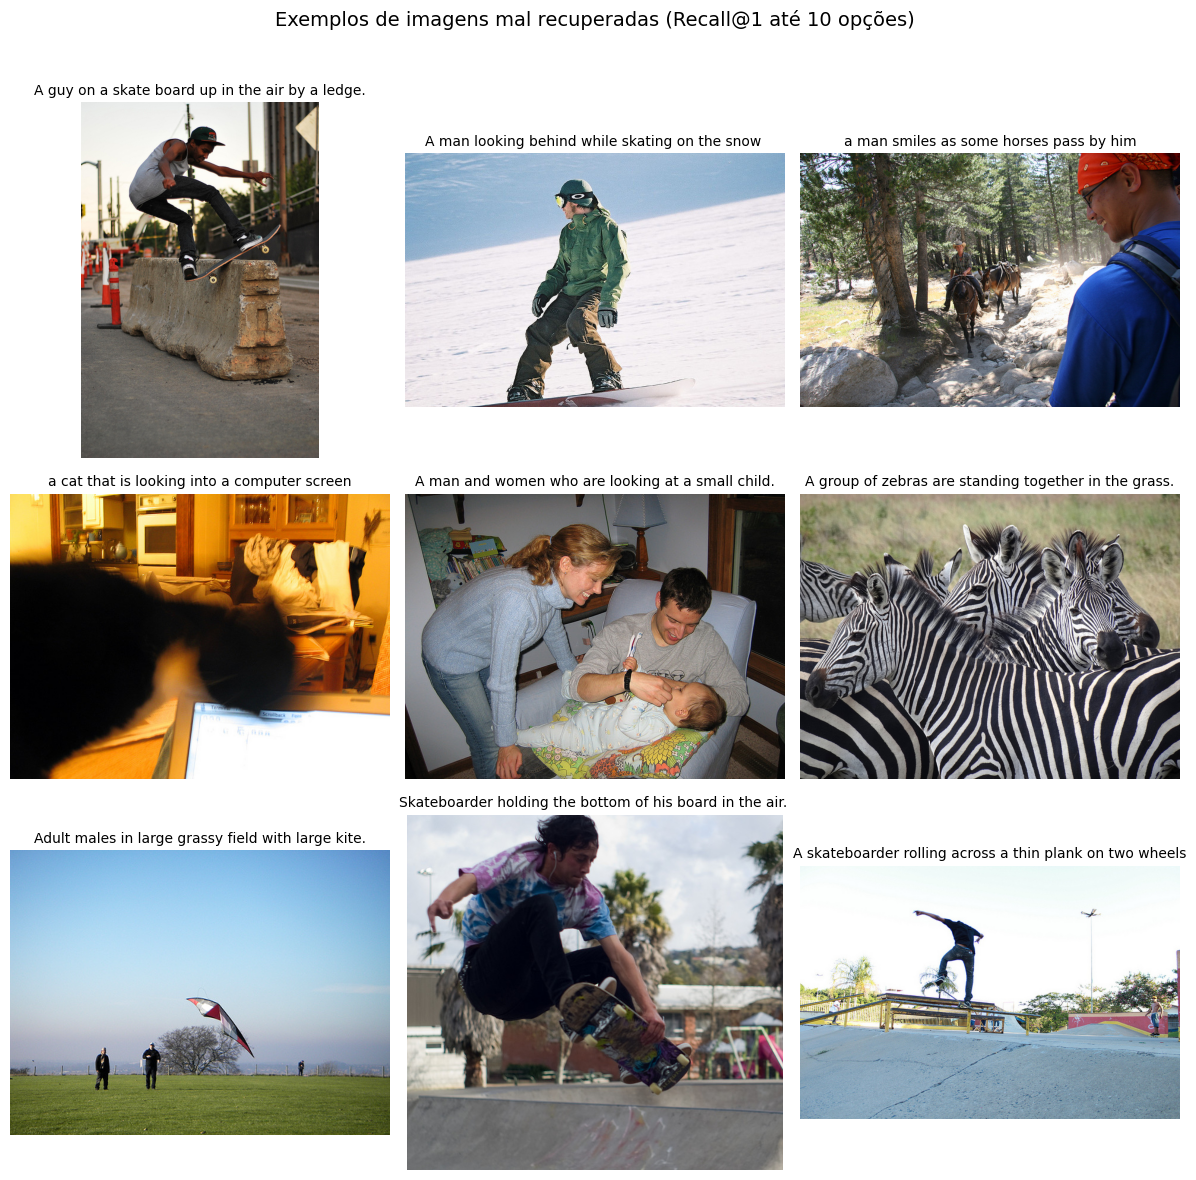

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image

errs = []
for ex, hit in zip(exemplos, df["hit@1"]):
    if hit == 0:
        errs.append({"id": ex["id_correto"], "legenda": ex["legenda"]})

N = 9
sample = random.sample(errs, N)

fig, axes = plt.subplots(3, 3, figsize=(12,12))
for ax, item in zip(axes.flatten(), sample):
    img_id = item["id"]
    caption = item["legenda"]
    path = f"{diretorio_val}/{str(img_id).zfill(12)}.jpg"
    img = Image.open(path)
    ax.imshow(img)
    ax.set_title(caption, fontsize=10)
    ax.axis("off")

plt.suptitle("Exemplos de imagens mal recuperadas (Recall@1 até 10 opções)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


,Ambíguas,Outros
0,a red and white bus and some cars in the rain,Two cows in a large green grassy field.
1,"A living area with a bed, chair and window.",Two surfers walking on a beach to the ocean.
2,"Patchy lawn, a road sign and a fire hydrant",A stop sign gives traffic a frown face.
3,Fresh fruits and vegetables piled in a wooden ...,a group of people who are posing for a picture
4,A display of a momma bear and her cub.,a cat is sleeping on the hood of a car
5,a street with traffic and wet roads from the rain,A man in a jacket standing near a giant tv
6,A vase filled with water and white flowers.,A row of several types of pastries on display.
7,A red and white train passing by a street.,A group of cows in a fenced in area.
8,an image of a plate of food with meat and veggies,A corner of a living room with a TV in it.
9,a blue and yellow train a building and some cars,A white plate with lots topped with garlic bread.


 1. A: a red and white bus and some cars in the rain
    B: Two cows in a large green grassy field.

 2. A: A living area with a bed, chair and window.
    B: Two surfers walking on a beach to the ocean.

 3. A: Patchy lawn, a road sign and a fire hydrant
    B: A stop sign gives traffic a frown face.

 4. A: Fresh fruits and vegetables piled in a wooden box.
    B: a group of people who are posing for a picture

 5. A: A display of a momma bear and her cub.
    B: a cat is sleeping on the hood of a car

 6. A: a street with traffic and wet roads from the rain
    B: A man in  a jacket standing near a  giant tv

 7. A: A vase filled with water and white flowers.
    B: A row of several types of pastries on display.

 8. A: A red and white train passing by a street.
    B: A group of cows in a fenced in area.

 9. A: an image of a plate of food with meat and veggies
    B: A corner of a living room with a TV in it.

10. A: a blue and yellow train a building and some cars
    B: A white 

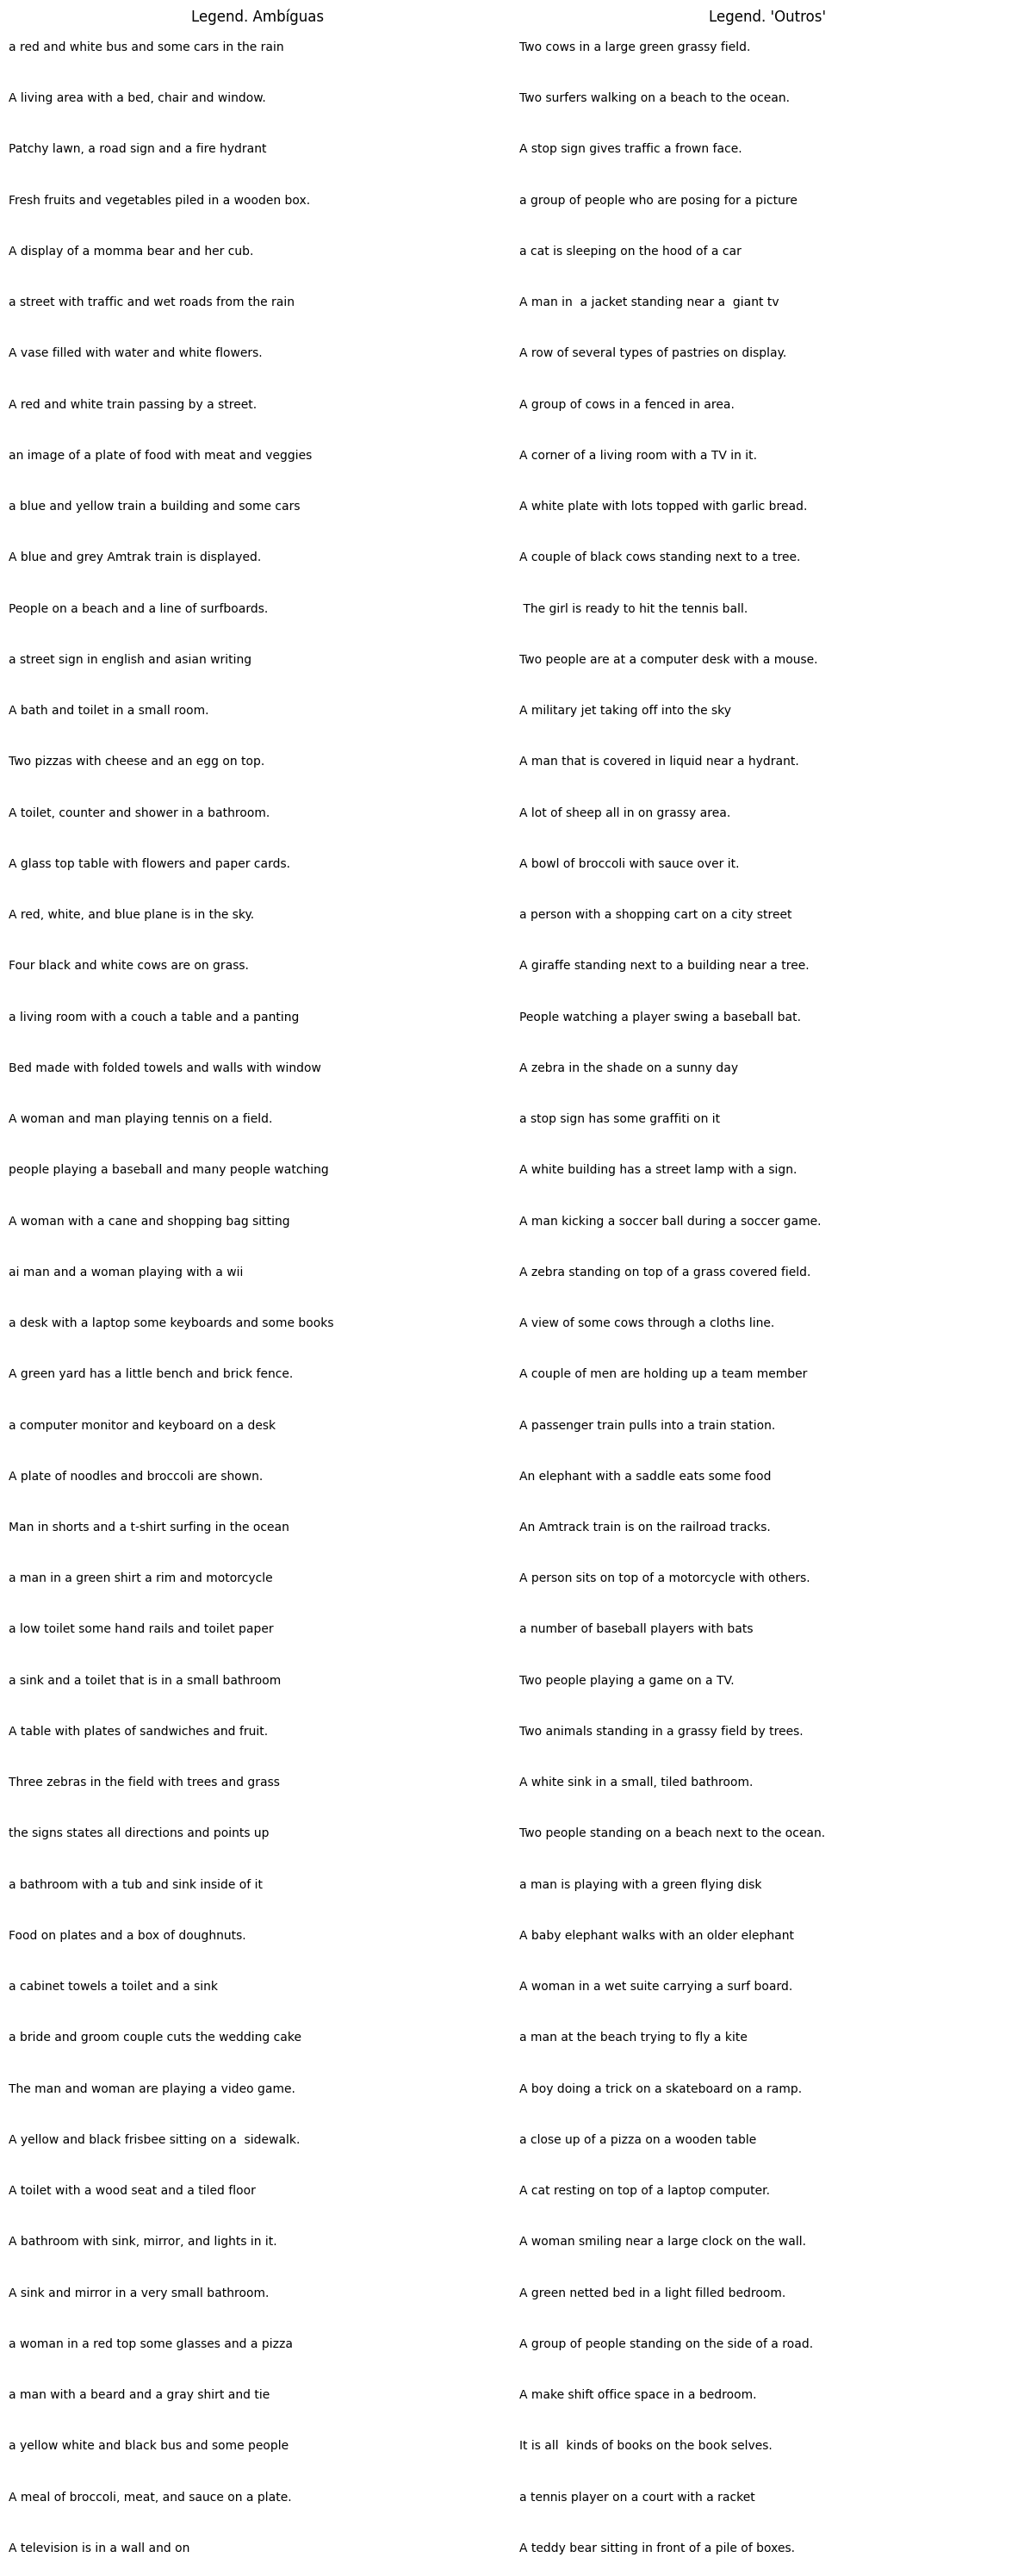

In [ ]:
import random
import pandas as pd

N = 50

legendas_amb = df_fail[df_fail["tipo_erro"] == "ambigua"]["legenda"] \
                  .sample(N, random_state=42) \
                  .reset_index(drop=True)

legendas_out = df_fail[df_fail["tipo_erro"] == "outros"]["legenda"] \
                  .sample(N, random_state=42) \
                  .reset_index(drop=True)

df_compare = pd.DataFrame({
    "Ambíguas": legendas_amb,
    "Outros":   legendas_out
})

display(df_compare)

for i in range(N):
    print(f"{i+1:2d}. A: {df_compare.loc[i, 'Ambíguas']}")
    print(f"    B: {df_compare.loc[i, 'Outros']}\n")


In [ ]:
# ─────────── 1) Filtrar acertos ───────────
df_success = df[df["hit@1"] == 1].copy()

# ─────────── 2) Amostrar N legendas corretas ───────────
import random
N = 50
leg_success = df_success["legenda"].sample(N, random_state=42).reset_index(drop=True)

# ─────────── 3) Exibir como DataFrame ───────────
import pandas as pd
df_success_sample = pd.DataFrame({
    "Legendas corretas (Recall@1)": leg_success
})
display(df_success_sample)

# ─────────── 4) Ou imprimir no console ───────────
for i, leg in enumerate(leg_success, 1):
    print(f"{i:2d}. {leg}")


,Legendas corretas (Recall@1)
0,Food is cooking inside of a microwave oven.
1,A woman talking on the phone in front of a per...
2,a statue is standing on top of a clock on a pole
3,A grey colored cat that is drinking from a gla...
4,A 70s themed living room displays an old tv.
5,a big boat on a river with a cityscape in the ...
6,Two dogs playing in the grass with a frisbee.
7,A man in black shirt standing in field with ba...
8,Plates of food and two glasses of red wine are...
9,A little girl eating a slice of pizza in a room.


 1. Food is cooking inside of a microwave oven.
 2. A woman talking on the phone in front of a person selling apples.
 3. a statue is standing on top of a clock on a pole
 4. A grey colored cat that is drinking from a glass of water.
 5. A 70s themed living room displays an old tv.
 6. a big boat on a river with a cityscape in the background 
 7. Two dogs playing in the grass with a frisbee.
 8. A man in black shirt standing in field with baseball mitt.
 9. Plates of food and two glasses of red wine are on a table.
10. A little girl eating a slice of pizza in a room.
11. two elephants walking in a field near a tree
12. A man sitting on a train next to a woman.
13. A large variety of fruits displayed for sale in a store.
14. A silver and black sports motorcycle parked near a building.
15. a piece of eaten corn next to a bunch of mixed veggies

16. A woman in lingerie laying on a bed.
17. The children are seated outside at the picnic table to eat the birthday party food.
18. Microwave an